In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import h5py
import os
import sys
import scipy
import damselfly as df
import mayfly as mf
import scipy.signal
import scipy.stats
import scipy.interpolate

PATH = '/storage/home/adz6/group/project'
RESULTPATH = os.path.join(PATH, 'results/damselfly')
PLOTPATH = os.path.join(PATH, 'plots/damselfly')
DATAPATH = os.path.join(PATH, 'datasets/data')
#SIMDATAPATH = os.path.join(PATH, 'damselfly/data/sim_data')

"""
Date: 6/25/2021
Description: template
"""


    


'\nDate: 6/25/2021\nDescription: template\n'

In [2]:
os.listdir(os.path.join(DATAPATH, 'bf'))

['211130_sens_est_dense_grid_84.5_0cm_sum.h5',
 '211130_sens_est_dense_grid_89.5_0cm_sum.h5',
 '211203_84_25_2cm_sum.h5',
 '220216_gradb_est_summed_data_needs_check.npy',
 '220222_gradb_est_summed_data.npy',
 '220223_gradb_est_summed_signals_with_pitch_rad.npz',
 '220225_dense_grid_87.0deg_1cm.npy',
 '220225_dense_grid_87.0deg_1cm_random.npy',
 '220301_dense_grid_87.0deg_1to4cm.npy',
 '220301_dense_grid_87.0deg_1to4cm_random.npy',
 '220301_dense_grid_87.0deg_2cm.npy',
 '220301_dense_grid_87.0deg_2cm_random.npy',
 '220301_dense_grid_87.0deg_3cm.npy',
 '220301_dense_grid_87.0deg_3cm_random.npy',
 '220301_dense_grid_87.0deg_4cm.npy',
 '220301_dense_grid_87.0deg_4cm_random.npy']

In [3]:
os.listdir(os.path.join(PATH, 'datasets', 'kass'))

['211116_grad_b_est_kass.h5',
 '211129_sens_est_dense_grid_84.5_0cm_kass.h5',
 '211129_sens_est_dense_grid_89.5_0cm_kass.h5',
 '211221_sens_est_dense_grid_84.5_0cm_random_kass.h5',
 '211221_sens_est_dense_grid_87.0_0cm_random_kass.h5',
 '211221_sens_est_dense_grid_89.5_0cm_random_kass.h5',
 '220107_sens_est_dense_grid_84.5_4cm_kass.h5',
 '220107_sens_est_dense_grid_87.0_0cm_kass.h5',
 '220107_sens_est_dense_grid_87.0_4cm_kass.h5',
 '220107_sens_est_dense_grid_89.5_4cm_kass.h5',
 '220112_sens_est_dense_grid_84.5_2cm_kass.h5',
 '220112_sens_est_dense_grid_84.5_2cm_random_kass.h5',
 '220112_sens_est_dense_grid_84.5_4cm_random_kass.h5',
 '220112_sens_est_dense_grid_87.0_2cm_kass.h5',
 '220112_sens_est_dense_grid_87.0_4cm_random_kass.h5',
 '220112_sens_est_dense_grid_89.5_2cm_kass.h5',
 '220112_sens_est_dense_grid_89.5_2cm_random_kass.h5',
 '220112_sens_est_dense_grid_89.5_4cm_random_kass.h5',
 '220117_sens_est_dense_grid_84.5_1cm_kass.h5',
 '220117_sens_est_dense_grid_87.0_1cm_kass.h5',
 '

# load data

In [4]:
# signal data
data = mf.data.MFDataset(os.path.join(DATAPATH, 'bf', '211203_84_25_2cm_sum.h5'))
metadata = pd.DataFrame(data.metadata)

# kass data
h5kass_data = h5py.File(os.path.join(PATH, 'datasets', 'kass', '211116_grad_b_est_kass.h5'), 'r')

kass_data = h5kass_data['kass']
kass_metadata = {}
for i, key in enumerate(h5kass_data['meta'].keys()):
    kass_metadata[key] = h5kass_data['meta'][key][:]
    
kass_metadata = pd.DataFrame.from_dict(kass_metadata)

# compute MF scores

In [5]:
slicesize = 8192

data_slice = data.data[:, 0:slicesize]



In [6]:
var = 1.38e-23 * 3 * 50 * 60 * 200e6

templates = data_slice * 1 / np.sqrt(var * (abs(data_slice) ** 2).sum(axis=-1) ).reshape(data_slice.shape[0],1)

scores = abs(np.sum(data_slice * templates.conjugate(), axis=-1))
print(scores.mean())

7.6890993


# plot example mf score pdf's

In [24]:
signal = data_slice[6000, :]
template = templates[6000, :]

sample_scores = np.zeros(100000)
for i in range(100000):

    noise = np.random.multivariate_normal([0, 0], np.eye(2) * var / 2, signal.size)
    noise = noise[:, 0] + 1j * noise[:, 0]
    
    score = abs(np.vdot(template, noise))
    sample_scores[i] = score

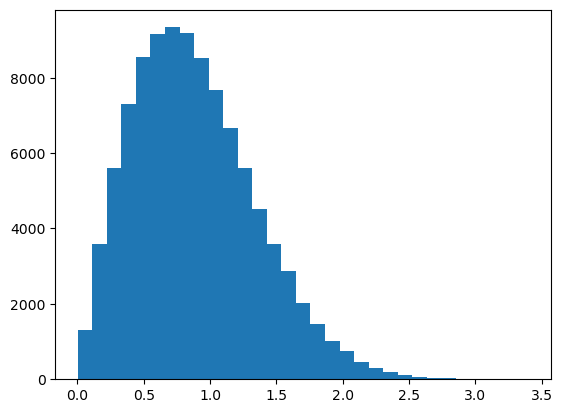

In [25]:
hist = plt.hist(sample_scores, 31)

(-0.25, 6.0)

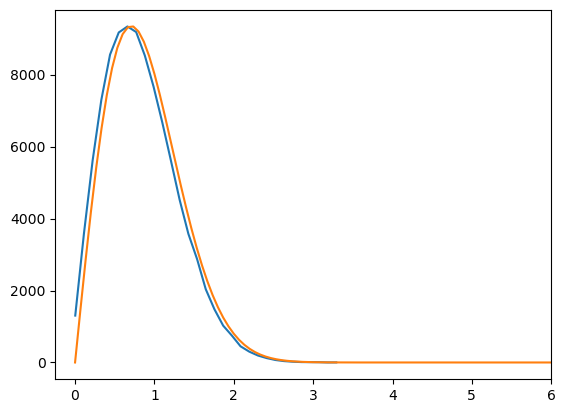

In [35]:

x_rice = np.linspace(0, 20, 301)
y_rice = scipy.stats.rice.pdf(x_rice, 0, loc=0.0, scale=1/np.sqrt(2))

plt.plot(hist[1][0:31], hist[0])
plt.plot(x_rice, 10900 * y_rice, label='Rician')
plt.xlim(-0.25, 6)

In [54]:
i_signal = 2000
n_trial = 50000
signal = data_slice[i_signal, :]
template = templates[i_signal, :]

sample_scores = np.zeros(n_trial)
sample_noise = np.zeros(n_trial)
for i in range(n_trial):

    noise = np.random.multivariate_normal([0, 0], np.eye(2) * var / 2, signal.size)
    noise = noise[:, 0] + 1j * noise[:, 0]
    
    score = abs(np.vdot(template, signal + noise))
    score_noise = abs(np.vdot(template, noise))
    sample_scores[i] = score
    sample_noise[i] = score_noise

Text(0.5, 1.0, 'Example MF Score Distributions')

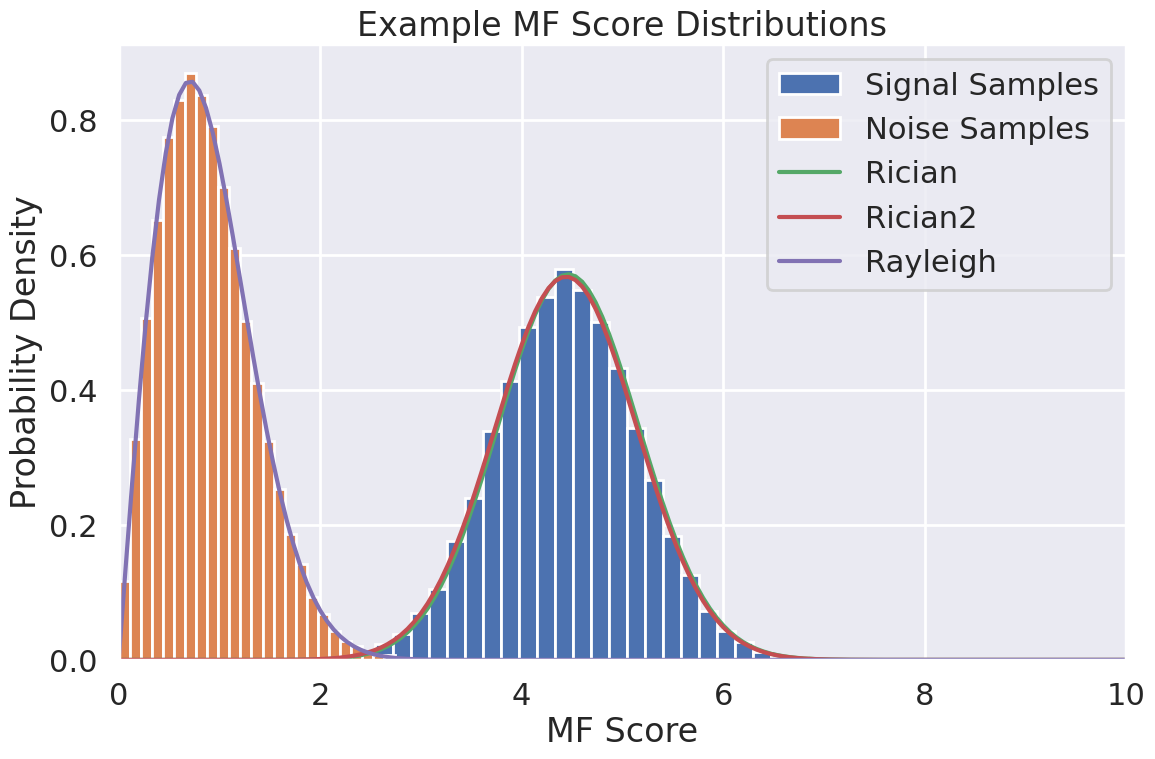

In [55]:
sns.set_theme(context='poster')
fig = plt.figure(figsize=(13,8))

ax = fig.add_subplot(1,1,1)

x_rice = np.linspace(0, 20, 301)
y_rice = scipy.stats.rice.pdf(x_rice , scores[i_signal], loc=scores[i_signal] * (1-1/np.sqrt(2)),  scale = 1/np.sqrt(2))
y_rice2 = scipy.stats.rice.pdf(x_rice , np.sqrt(2) * scores[i_signal],  scale = 1/np.sqrt(2))
#scores[6000] * (1-1/np.sqrt(2))
x_ray = np.linspace(0, 20, 301)
y_ray = scipy.stats.rice.pdf(x_rice , 0,scale = 1/np.sqrt(2))

ax.hist(sample_scores, 31, density=True, label = 'Signal Samples')
ax.hist(sample_noise, 31, density=True, label='Noise Samples')
ax.plot(x_rice, y_rice, label='Rician')
ax.plot(x_rice, y_rice2, label='Rician2')
ax.plot(x_ray, y_ray, label='Rayleigh')
ax.set_xlim(0, 10)

ax.set_xlabel('MF Score')
ax.legend(loc=1)
ax.set_ylabel('Probability Density')
ax.set_title('Example MF Score Distributions')

#plt.savefig(os.path.join(PATH, 'plots/mayfly', '220107_example_rician_and_rayleigh_mf_score_dist'))

# pick a threshold

(0.0, 8.0)

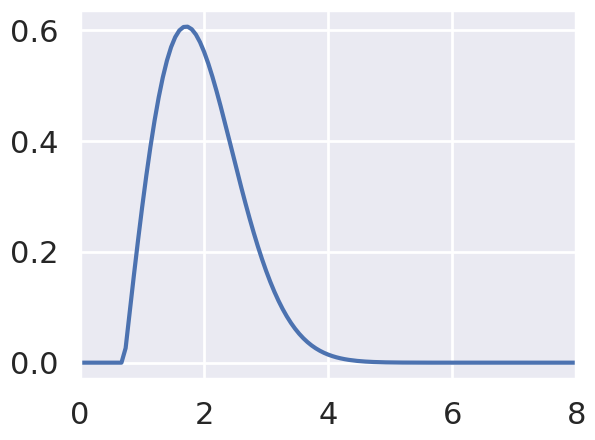

In [13]:
plt.figure()

plt.plot(x_rayleigh, y_rayleigh, label='Rayleigh')
plt.xlim(0, 8)

5.4 0.999983491305585


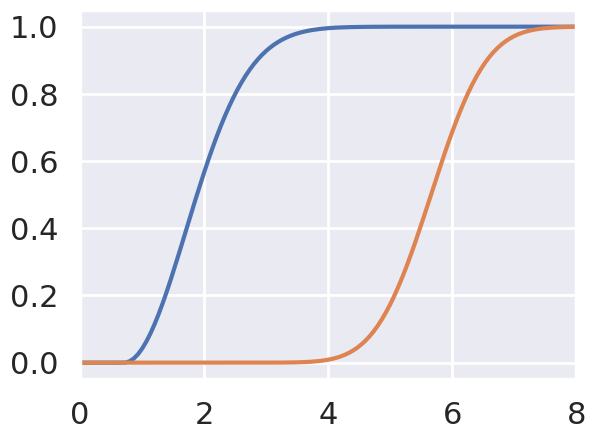

In [14]:
y_rayleigh = scipy.stats.rice.cdf(x_rayleigh, 0, 1/np.sqrt(2))
y_rice = scipy.stats.rice.cdf(x_rice, scores[4000], scores[4000] * (1-1/np.sqrt(2)), 1/np.sqrt(2))


plt.figure()

plt.plot(x_rayleigh, y_rayleigh, label='Rayleigh')
plt.plot(x_rice, y_rice, label='Rayleigh')
plt.xlim(0, 8)
print(x_rayleigh[81], y_rayleigh[81])



5.4 2.1671553440683056e-13


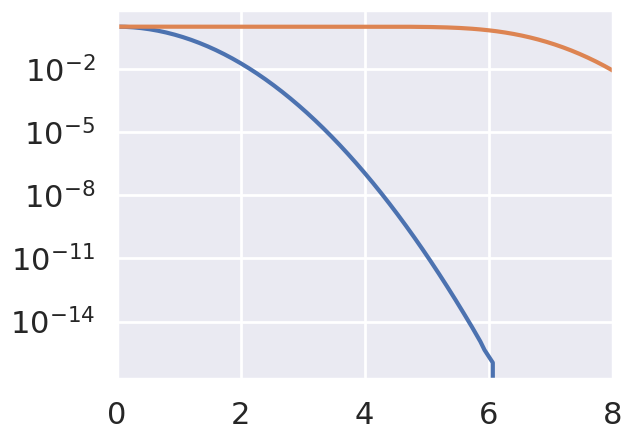

In [15]:
y_rayleigh = scipy.stats.rice.sf(x_rayleigh, 0, scale=1/np.sqrt(2))
y_rice = scipy.stats.rice.sf(x_rice, scores[5000], scores[5000] * (1-1/np.sqrt(2)), scale=1/np.sqrt(2))


plt.figure()

plt.plot(x_rayleigh, y_rayleigh, label='Rayleigh')
plt.plot(x_rice, y_rice, label='Rayleigh')
plt.xlim(0, 8)
print(x_rayleigh[81], y_rayleigh[81])
plt.yscale('log')

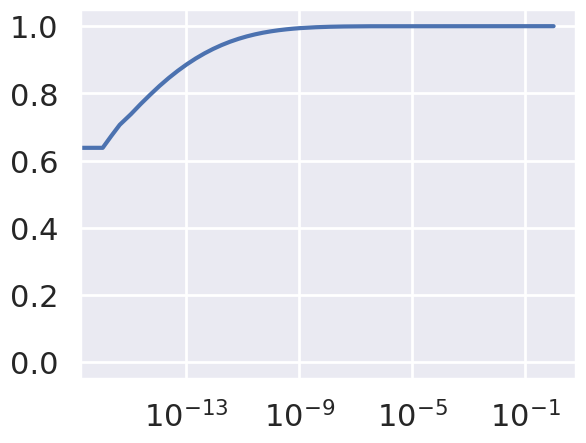

In [16]:
plt.plot(y_rayleigh, y_rice)

plt.xscale('log')

In [17]:
y_rice = scipy.stats.rice.sf(x_rice, scores.reshape(scores.size, 1), (scores * (1-1/np.sqrt(2))).reshape(scores.size, 1), scale=1/np.sqrt(2))

In [18]:
mean_sf = np.mean(y_rice, axis=0)

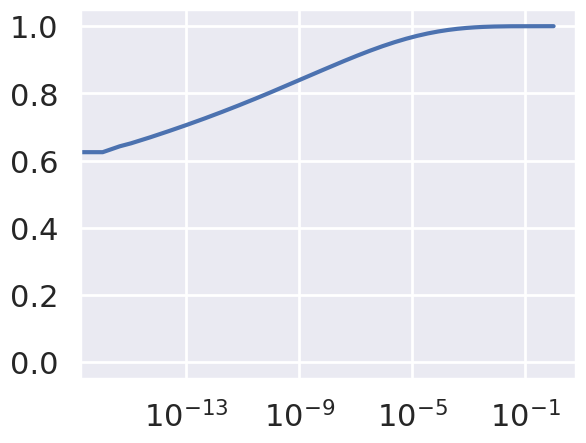

In [19]:
plt.plot(y_rayleigh, mean_sf)

plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-3, 1)
#plt.ylim(0.9, 1)

In [20]:
score_sample = scipy.stats.rice.rvs(scores, size=scores.size)

In [21]:
len(np.argwhere(score_sample >= 3.4)) / len(scores)

0.9527043613452254

In [22]:
print(scores.mean())

7.6890993


# plot MF ROC curves vs temp

1
3
5
10
13


Text(0.5, 1.0, 'Ideal MF ROC Curves')

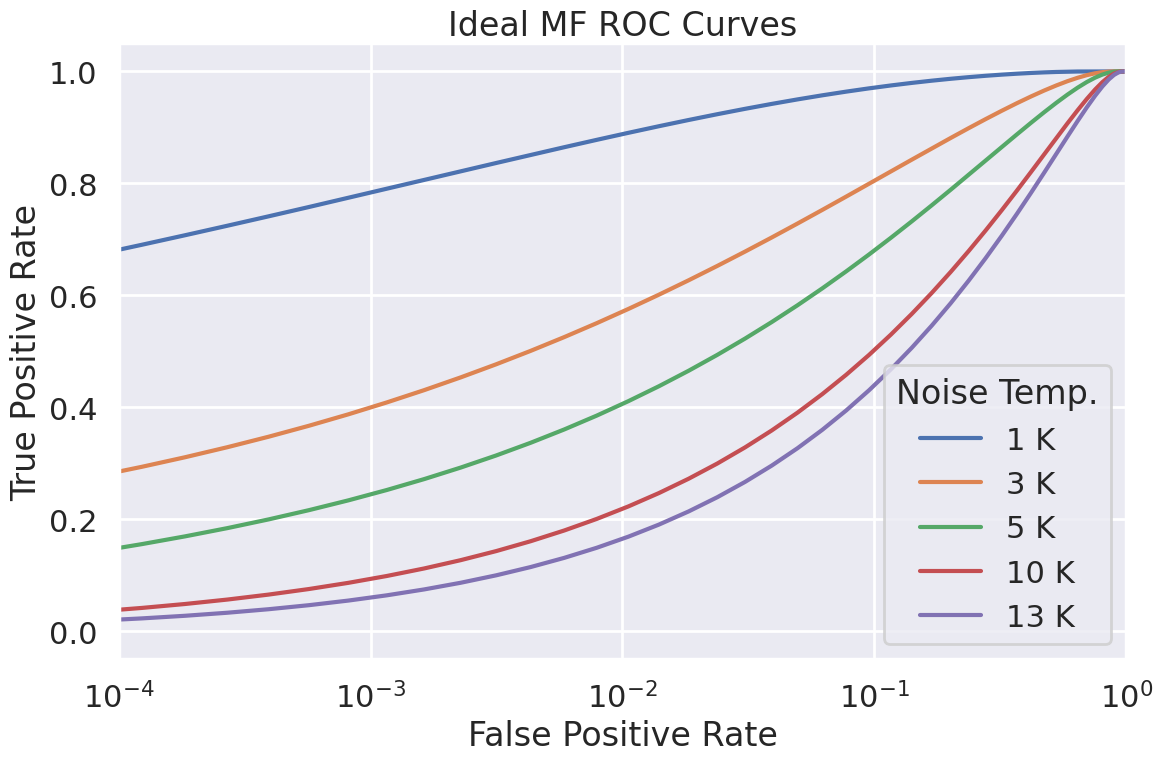

In [23]:
sns.set_theme(context='poster')

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

x = np.linspace(0, 20, 301)
y_rayleigh = scipy.stats.rice.sf(x, 0, scale=1/np.sqrt(2))

for temp in [1, 3, 5, 10, 13]:
    print(temp)

    var = 1.38e-23 * temp * 50 * 60 * 200e6

    templates = data_slice * 1 / np.sqrt(var * (abs(data_slice) ** 2).sum(axis=-1) ).reshape(data_slice.shape[0],1)

    scores = abs(np.sum(data_slice * templates.conjugate(), axis=-1)) * 0.3
    
    y_rice = scipy.stats.rice.sf(x_rice, scores.reshape(scores.size, 1), (scores * (1-1/np.sqrt(2))).reshape(scores.size, 1), scale=1/np.sqrt(2))
    
    mean_sf = np.mean(y_rice, axis=0)
    
    ax.plot(y_rayleigh, mean_sf, label=f'{temp} K')
    
plt.legend(title='Noise Temp.', loc=4)
ax.set_xscale('log')
ax.set_xlim(1e-4, 1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Ideal MF ROC Curves')

#plt.savefig(os.path.join(PATH, 'plots/mayfly', '220107_idealized_mf_roc_curve'))

In [ ]:
file['train']['data'].shape

In [ ]:
plt.plot(file['train']['data'][0, 0, :])

In [ ]:
plt.plot(file['train']['data'][-1, 0, :])